### Generalized Addative Model for Panel Data

https://www.statsmodels.org/devel/mixed_linear.html

https://www.statsmodels.org/devel/gam.html

https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

#### Modeling Framework 
    1. Fit 3 models for each type of data 
        * GAM and / or spline model - because we have panel data 
    2. Tune spline parameters 
    3. Train / test split - not cross validate 
        * work on back testing modeling framework 
    4. Output: 
        1. Prediction
        2. A notion of variance or uncertainty for optimization 
    5. Pipeline to injest new data 

#### Loading Google API Utilities and Stats Packages

In [1]:
#importing statsmodels packages
import statsmodels.api as sm

from statsmodels.gam.api import GLMGam, BSplines

import statsmodels.formula.api as smf

In [2]:
#%load ../api_access_snippet.py
#import library
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials
# Print nicely
import pprint
#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

import pandas as pd 
import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

#### Reading the data 

In [5]:
passing = read_file('passing_data_model_ready')
rec = read_file('receiving_data_model_ready')
rush = read_file('rushing_data_model_ready')

#### Data Pred & Cleaning 

In [6]:
lags = passing.columns[passing.columns.str.contains(pat = 'lag\d_')].tolist()
ratio = ['yds_ratio', 'rate_ratio', 'fantasy_pts_ratio']
target = ['passing_fantasy_pts']
factors = ['Name', 'Team']

In [7]:
#getting the float vars set up 
fix = lags + ratio + target

passing[fix] = passing[fix].astype(float)

In [ ]:
#fixing ratios 
passing = passing.replace(np.inf, 0)

In [8]:
passing.describe()

,passing_fantasy_pts,lag3_Yds,lag3_TD,lag3_Rate,lag3_passing_fantasy_pts,lag1_Yds,lag1_TD,lag1_Rate,lag1_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,13.437101,208.350510,1.309179,88.715942,13.570735,207.586151,1.283414,87.680354,13.437101,inf,inf,inf
std,8.420377,98.232893,0.891742,26.032002,6.947738,112.130789,1.223506,32.331005,8.420377,NaN,NaN,NaN
min,-0.080000,-2.000000,0.000000,0.000000,-0.080000,-2.000000,0.000000,0.000000,-0.080000,0.000000,0.000000,0.000000
25%,7.320000,171.333333,0.666667,75.133333,10.306667,148.000000,0.000000,69.000000,7.320000,0.857310,0.883714,0.800000
50%,13.320000,229.333333,1.333333,90.433333,14.640000,220.000000,1.000000,87.900000,13.320000,1.000000,1.000000,1.000000
75%,19.120000,276.666667,2.000000,104.066667,18.213333,285.000000,2.000000,111.200000,19.120000,1.163708,1.164144,1.290395
max,37.160000,418.000000,5.000000,158.300000,32.960000,517.000000,5.000000,158.300000,37.160000,inf,inf,inf


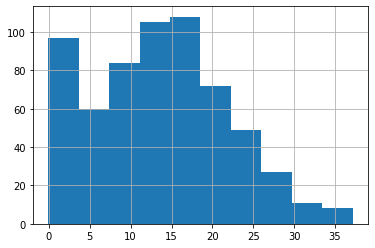

In [9]:
passing.passing_fantasy_pts.hist()
plt.show()

### Fitting GAM with Stats Models

In [15]:
inputs = lags + ratio
f = 'passing_fantasy_pts ~ lag3_Yds + lag3_TD + lag3_Rate + lag3_passing_fantasy_pts + lag1_Yds + lag1_TD + lag1_Rate + lag1_passing_fantasy_pts + yds_ratio + rate_ratio + fantasy_pts_ratio'

In [16]:
print(inputs)
print(f)

['lag3_Yds', 'lag3_TD', 'lag3_Rate', 'lag3_passing_fantasy_pts', 'lag1_Yds', 'lag1_TD', 'lag1_Rate', 'lag1_passing_fantasy_pts', 'yds_ratio', 'rate_ratio', 'fantasy_pts_ratio']
passing_fantasy_pts ~ lag3_Yds + lag3_TD + lag3_Rate + lag3_passing_fantasy_pts + lag1_Yds + lag1_TD + lag1_Rate + lag1_passing_fantasy_pts + yds_ratio + rate_ratio + fantasy_pts_ratio


In [17]:
pass_mdl_data = passing[target + inputs]

In [18]:
complexity = 3
num_vars = len(inputs)

df_iter = np.repeat(complexity, num_vars)
degrees = np.repeat(complexity - 1, num_vars)

In [19]:
x_spline = passing[inputs]

bs = BSplines(x_spline, df = df_iter, degree = degrees)

In [20]:
pass_gam = GLMGam.from_formula(f, data = pass_mdl_data, smoother = bs)

In [26]:
pass_results = pass_gam.fit()

PerfectSeparationError: Perfect separation detected, results not available

In [21]:
pass_mdl_data.head()

,passing_fantasy_pts,lag3_Yds,lag3_TD,lag3_Rate,lag3_passing_fantasy_pts,lag1_Yds,lag1_TD,lag1_Rate,lag1_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
0,24.72,418.0,2.0,106.5,24.72,418.0,2.0,106.5,24.72,1.0,1.0,1.0
1,32.20,405.0,4.0,158.3,32.20,405.0,4.0,158.3,32.20,1.0,1.0,1.0
2,27.40,385.0,3.0,110.0,27.40,385.0,3.0,110.0,27.40,1.0,1.0,1.0
3,27.20,380.0,3.0,117.6,27.20,380.0,3.0,117.6,27.20,1.0,1.0,1.0
4,27.12,378.0,3.0,143.2,27.12,378.0,3.0,143.2,27.12,1.0,1.0,1.0


In [25]:
pass_gam.

#### Using pyGAM to fit the GAM

In [ ]:
from pygam import linearnGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
#tuning grid bs 
lams = np.random.rand(100, 11)
lams = lams * 11 - 3
lams = np.exp(lams)
splines = [2, 4, 6, 10, 12]
constraint_sets = ['monotonic_inc', 'concave', 'None']

In [ ]:
#setting up the data 
x = 